#**원본 데이터셋(from Github) 내려받기**

In [ ]:
!git clone 'https://github.com/Shenggan/BCCD_Dataset.git'

#**데이터 전처리 단계 시작**

# .xml 파일로부터 데이터 라벨 추출하여 dataframe으로 변환하기

In [2]:
# 사용할 라이브러리 호출

import shutil
import os, sys, random
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import os

In [3]:
# 해당 경로의 annotation 파일(.xml) 읽어오기
# annotations = ['/content/BCCD_Dataset/BCCD/Annotations/BloodImage_00000.xml', '/content/BCCD_Dataset/BCCD/Annotations/BloodImage_00001.xml', ... ]
annotations = sorted(glob('/content/BCCD_Dataset/BCCD/Annotations/*.xml'))

# 각 파일을 순회하며 이미지별 Object의 annotation 정보 (name, Xmin, Xmax, Ymin, Ymax) 읽어오기
# 읽은 정보는 리스트(df)에 담기
df = []
cnt = 0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = str(cnt) + '.jpg'
  row = []
  parsedXML = ET.parse(file)
  for node in parsedXML.getroot().iter('object'):
    blood_cells = node.find('name').text
    xmin = int(node.find('bndbox/xmin').text)
    xmax = int(node.find('bndbox/xmax').text)
    ymin = int(node.find('bndbox/ymin').text)
    ymax = int(node.find('bndbox/ymax').text)

    row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
    df.append(row)
  cnt += 1

# 읽어온 정보를 취합하여 pandas 라이브러리를 사용해 활용 가능한 데이터 단위인 Data Frame으로 변환하기
data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

# 데이터프레임을 csv로 저장
data[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('/content/blood_cell_detection.csv', index=False)


# YOLOv5 데이터 형식에 따른 데이터 처리

**데이터프레임(Dataframe) 구조**

- filename : 이미지 이름
- cell_type: 셀의 유형
- xmin:이미지 좌하단의 x 좌표
- xmax: 이미지 우상단의 x 좌표
- ymin: 이미지 좌하단의 y 좌표
- ymax: 이미지 우상단의 y 좌표
- labels : 인코딩된 셀 타입 **(Yolo - label input-1)**
- width : bbox(바운딩 박스)의 너비
- height : bbox의 높이
- x_center : bbox의 x축 중심 좌표
-	y_center : bbox의 y축 중심 좌표
-	x_center_norm	: x_center 정규화 값 (0-1) **(Yolo - label input-2)**
-	y_center_norm : y_center 정규화 값 (0-1) **(Yolo - label input-3)**
- width_norm : width 정규화 값 (0-1) **(Yolo - label input-4)**
-	height_norm : height 정규화 값 (0-1) **(Yolo - label input-5)**

In [7]:
# 정규화 계산에 필요한 이미지 width, height
img_width = 640
img_height = 480

# 산술용 함수 정의
def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))
def w_norm(df):
  return df/img_width
def h_norm(df):
  return df/img_height

# 미리 정의한(저장한) csv로부터 데이터프레임 생성
df = pd.read_csv('/content/blood_cell_detection.csv')

# 사이킷런(Scikit-Learn) 라이브러리의 preprocessing가 제공하는 LabelEncoder 호출
# 데이터프레임의 cell_type 값을 라벨로 활용하겠다고 지정
# le.classes_ : ['Platelets' 'RBC' 'WBC']
le = preprocessing.LabelEncoder()
le.fit(df['cell_type'])
print(le.classes_)

# 데이터프레임의 cell_type 값을 [0, 1, 2]에 대응하도록 변경(labels) 및 데이터프레임에 'labels' 컬럼으로 추가
# labels: [2 1 1 ... 0 0 2]
labels = le.transform(df['cell_type'])
df['labels'] = labels
print(labels)

# df.apply() 함수를 이용하여 위에서 정의한 산술 값을 계산하여 컬럼에 추가
df['width'] = df.apply(width, axis=1)
df['height'] = df.apply(height, axis=1)

df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df['x_center'].apply(w_norm)
df['width_norm'] = df['width'].apply(w_norm)

df['y_center_norm'] = df['y_center'].apply(h_norm)
df['height_norm'] = df['height'].apply(h_norm)

# 데이터프레임의 데이터 상위 30개 출력
df.head(30)

['Platelets' 'RBC' 'WBC']
[2 1 1 ... 0 0 2]


,prev_filename,filename,cell_type,xmin,xmax,ymin,ymax,labels,width,height,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,BloodImage_00000.jpg,0.jpg,WBC,260,491,177,376,2,231,199,375,276,0.585938,0.360938,0.575000,0.414583
1,BloodImage_00000.jpg,0.jpg,RBC,78,184,336,435,1,106,99,131,385,0.204687,0.165625,0.802083,0.206250
2,BloodImage_00000.jpg,0.jpg,RBC,63,169,237,336,1,106,99,116,286,0.181250,0.165625,0.595833,0.206250
3,BloodImage_00000.jpg,0.jpg,RBC,214,320,362,461,1,106,99,267,411,0.417187,0.165625,0.856250,0.206250
4,BloodImage_00000.jpg,0.jpg,RBC,414,506,352,445,1,92,93,460,398,0.718750,0.143750,0.829167,0.193750
5,BloodImage_00000.jpg,0.jpg,RBC,555,640,356,455,1,85,99,597,405,0.932813,0.132812,0.843750,0.206250
6,BloodImage_00000.jpg,0.jpg,RBC,469,567,412,480,1,98,68,518,446,0.809375,0.153125,0.929167,0.141667
7,BloodImage_00000.jpg,0.jpg,RBC,1,87,333,437,1,86,104,44,385,0.068750,0.134375,0.802083,0.216667
8,BloodImage_00000.jpg,0.jpg,RBC,4,95,406,480,1,91,74,49,443,0.076563,0.142187,0.922917,0.154167
9,BloodImage_00000.jpg,0.jpg,RBC,155,247,74,174,1,92,100,201,124,0.314063,0.143750,0.258333,0.208333


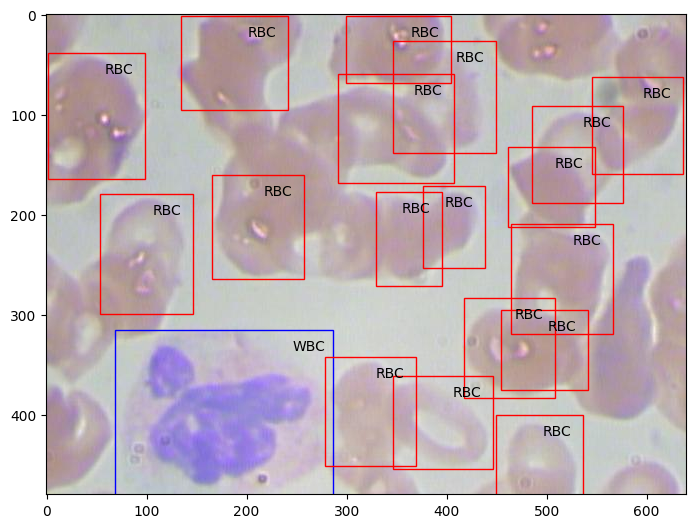

In [9]:
#@title 샘플 데이터 확인하기
# 이미지 크기: shape (480, 640, 3)

# 빈 그래프 이미지 생성
fig = plt.figure()

# 이미지 처리를 위한 openCV 라이브러리 호출
import cv2

#그래프 이미지에 축(공간) 추가
ax = fig.add_axes([0,0,1,1])

# 이미지 불러오기 및 그래프에 추가
image = plt.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00001.jpg')
plt.imshow(image)

# 이미지의 여러 객체들로 구성한 df(데이터프레임) 중 filename 값이 1.jpg인 객체들을 순회하며 for문 수행
for _,row in df[df.filename == "1.jpg"].iterrows():
    xmin = row.xmin
    xmax = row.xmax
    ymin = row.ymin
    ymax = row.ymax

    width = xmax - xmin
    height = ymax - ymin

    # 라벨로 지정한 cell_tpye 값에 따라서 RBC: Red, WBC: Blue, Platelets: Green으로 색 지정 및 annotate 수행
    if row.cell_type == 'RBC':
        edgecolor = 'r'
        ax.annotate('RBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'WBC':
        edgecolor = 'b'
        ax.annotate('WBC', xy=(xmax-40,ymin+20))
    elif row.cell_type == 'Platelets':
        edgecolor = 'g'
        ax.annotate('Platelets', xy=(xmax-40,ymin+20))

    # 객체의 좌표와 지정한 색을 이용하여 사각형 그리기
    rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = edgecolor, facecolor = 'none')

    # 그래프 이미지에 추가한 축(공간)에 사각형 추가
    ax.add_patch(rect)

# 데이터셋 분할 (학습 데이터셋 및 검증 데이터셋)

In [10]:
# 사이킷런 라이브러리를 이용하여 데이터프레임을 train, valid로 분할 (train:valid = 9:1)
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_valid.shape) # (4399, 16) (489, 16) -> (데이터 수, 컬럼 수)


(4399, 16) (489, 16)


In [ ]:
# bcc(blood cell count) 관련 디렉토리 생성
os.mkdir('/content/bcc/')
os.mkdir('/content/bcc/images/')
os.mkdir('/content/bcc/images/train/')
os.mkdir('/content/bcc/images/valid/')

os.mkdir('/content/bcc/labels/')
os.mkdir('/content/bcc/labels/train/')
os.mkdir('/content/bcc/labels/valid/')

# 데이터 분리 및 해당 디렉토리로 이동
- BCC
  - Images
    - Train (364 images [.jpg files])
    - Valid (270 images [.jpg files])
  - Labels
    - Train (364 labels [.txt files])
    - Valid (270 labels [.txt files])


**.txt 파일 구조**

- 객체 당 행 1개
- 각 행은 [class x_center y_center width height] 형식
- 박스 좌표는 정규화(0~1)된 xywh 값
  (만약 정규화되지 않은 픽셀 값일 경우 x_center, y_center 값을 이미지 너비, 높이로 나누어 정규화 필요)
- 클래스 번호는 0부터 시작.


<img src="https://github.com/bala-codes/Yolo-v5_Object_Detection_Blood_Cell_Count_and_Detection/blob/master/imgs/label_txt.PNG?raw=true" width="50%">


In [ ]:
# 데이터 분리 함수
def segregate_data(df, img_path, label_path, train_img_path, train_label_path):

  # 데이터프레임의 filename 컬럼 값을 모두 리스트에 넣은 후, set()을 통해 중복 제거
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)

  # 중복을 제거한 filename을 순회하며
  for filename in filenames:
    yolo_list = []
    # 데이터프레임의 filename 컬럼이 같은 데이터들의 객체를 순회하며
    # yolo_list에 라벨 및 좌표정보 넣기
    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    # 추출한 yolo 객체 정보(yolo_list)를 [함수 호출시 매개변수로 받은 경로(train_label_path)/이미지 파일 이름.txt] 형식으로 yolo_list를 저장
    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.prev_filename.split('.')[0])+".txt")
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])

    # 해당 이미지를 함수 호출시 [매개변수로 받은 경로(train_img_path)/이미지 파일 이름.확장자]로 복사
    shutil.copyfile(os.path.join(img_path,row.prev_filename), os.path.join(train_img_path,row.prev_filename))

In [ ]:
%%time
# 위에서 정의한 함수를 이용하여 train, valid 데이터셋 환경 만들기
# 각 경로를 지정하고, 미리 분리해둔 데이터프레임을 각각 넣어 호출
src_img_path = "/content/BCCD_Dataset/BCCD/JPEGImages/"
src_label_path = "/content/BCCD_Dataset/BCCD/Annotations/"

train_img_path = "/content/bcc/images/train"
train_label_path = "/content/bcc/labels/train"

valid_img_path = "/content/bcc/images/valid"
valid_label_path = "/content/bcc/labels/valid"

segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

In [ ]:
# 현재 보고있는 노트북 파일(.ipynb)을 실행시키며 생긴 캐시 파일 제거
try:
  shutil.rmtree('/content/bcc/images/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('/content/bcc/images/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('/content/bcc/labels/train/.ipynb_checkpoints')
except FileNotFoundError:
  pass

try:
  shutil.rmtree('/content/bcc/labels/valid/.ipynb_checkpoints')
except FileNotFoundError:
  pass

# 불필요한 파일 제거 후 train, valid 디렉토리 내 파일 수
print("No. of Training images", len(os.listdir('/content/bcc/images/train')))
print("No. of Training labels", len(os.listdir('/content/bcc/labels/train')))

print("No. of valid images", len(os.listdir('/content/bcc/images/valid')))
print("No. of valid labels", len(os.listdir('/content/bcc/labels/valid')))

# **데이터 전처리 단게 완료**

#**YOLO v5 단계 시작**

# YOLO v5 Repository 내려받기(clone)
More can be found at here : [yolo](https://github.com/ultralytics/yolov5)

In [ ]:
!git clone  'https://github.com/ultralytics/yolov5.git'

In [1]:
# pip를 통해 필요 라이브러리(requirements) 다운로드
# (imageIO 에러 발생 시 한번 더 실행)
!pip install -qr '/content/yolov5/requirements.txt'
!pip install ImageIO

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/content/yolov5/requirements.txt'


# 학습을 위한 정보를 .yaml 파일로 작성해 yolov5 디렉토리로 이동시켜야 함

#**YAML 파일 작성 내용**

train: /content/bcc/images/train                    
val: /content/bcc/images/valid

nc: 3

names: ['Platelets', 'RBC', 'WBC']


<img src="https://github.com/bala-codes/Yolo-v5_Object_Detection_Blood_Cell_Count_and_Detection/blob/master/imgs/bcc_yaml.PNG?raw=true" width="50%">



In [ ]:
# echo 결과를 bcc.yaml 파일로 출력하여 .yaml 파일 생성
!echo -e 'train: /content/bcc/images/train\nval: /content/bcc/images/valid\n\nnc: 3\nnames: ['Platelets', 'RBC', 'WBC']' >> bcc.yaml
!cat 'bcc.yaml'

In [ ]:
shutil.copyfile('/content/bcc.yaml', '/content/yolov5/bcc.yaml')

#**Also edit the number of classes (nc) in the ./models/*.yaml file**

Choose the yolo model of your choice, here I chose yolov5s.yaml (yolo - small)


In [ ]:
# 모델 설정 파일(config)의 nc(라벨 수)를 80에서 3으로 변경
!sed -i 's/nc: 80/nc: 3/g' ./yolov5/models/yolov5s.yaml

<img src="https://cdn-images-1.medium.com/max/600/1*hCE5VwKkqHlZW466umYTTA.png">

# 학습 명령어

**학습 파라미터**
- train.py 파일 위치
- img 이미지 너비
- batch 배치 사이즈(학습 할 때 전체 데이터를 몇 개의 단위의 묶음으로 처리할지 결정)
- epochs 에폭 수(몇 번 학습할건지 반복 횟수 결정)
- data 학습 데이터 관련 .yaml 파일
- cfg 모델 설정 관련 .yaml 파일
- name 학습 중 최고 성능 모델의 이름을 무엇으로 저장할 것인지

!python
- <'location of train.py file'>
- --img <'width of image'>
- --batch <'batch size'>
- --epochs <'no of epochs'>
- --data <'location of the .yaml file'>
- --cfg <'Which yolo configuration you want'>(yolov5s/yolov5m/yolov5l/yolov5x).yaml | (small, medium, large, xlarge)
- --name <'Name of the best model after training'>

**학습 프로세스의 Metrics**
- Precision: 정밀도
- Recall: 재현율
- (참고: https://ctkim.tistory.com/entry/mAPMean-Average-Precision-%EC%A0%95%EB%A6%AC)
**No.of classes, No.of images, No.of targets, Precision (P), Recall (R), mean Average Precision (map)**
- Class | Images | Targets | P | R | mAP@.5 | mAP@.5:.95: |
- all   | 270    |     489 |    0.0899 |       0.827 |      0.0879 |      0.0551

In [ ]:
%%time
# 학습 명령어 입력
!python yolov5/train.py --img 640 --batch 8 --epochs 35 --data bcc.yaml --cfg yolov5/models/yolov5s.yaml --name BCCM

# 학습 모델을 통한 결과 예측(Single Image Prediction)

**Inference Parameters**
- detect 파일 위치
- source 예측할 이미지(single) 혹은 디렉토리 경로(Batch)
- weight 사용할 모델 가중치
!python
- <'location of detect.py file'>
- --source <'location of image/ folder to predict'>
- --weight <'location of the saved best weights'>
- --output <'location of output files after prediction'>

In [ ]:
shutil.rmtree('/content/yolov5/runs/detect/exp/') # 결과 출력 디렉토리 비우기
# 결과 예측 명령어 호출
output = !python yolov5/detect.py --source /content/bcc/images/valid/BloodImage_00000.jpg --weights '/content/yolov5/runs/train/BCCM/weights/best.pt'

disp_images = glob('/content/yolov5/runs/detect/exp/*')
img = plt.imread(disp_images[0])
plt.imshow(img)

# 학습 모델을 통한 결과 예측(Batch Prediction)

In [ ]:
# 예측 명령어 입력
shutil.rmtree('/content/yolov5/runs/detect/exp/') # 결과 출력 디렉토리 비우기
!python yolov5/detect.py --source /content/bcc/images/valid/ --weights '/content/yolov5/runs/train/BCCM/weights/best.pt'

In [ ]:
disp_images = glob('/content/yolov5/runs/detect/exp/*')
fig=plt.figure(figsize=(20, 28))
columns = 3
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.choice(disp_images)
    img = plt.imread(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# You need these files, if you wish to move the model to production

## Files

In [ ]:
shutil.copyfile('/content/yolov5/detect.py', '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/detect.py')
shutil.copyfile('/content/yolov5/requirements.txt', '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/requirements.txt')
shutil.copyfile('/content/runs/exp2_BCCM/weights/best_BCCM.pt', '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/best_BCCM.pt')



## Folder

In [ ]:
!cp -r '/content/yolov5/models' '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/'
!cp -r '/content/yolov5/utils' '/content/drive/My Drive/Machine Learning Projects/YOLO/SOURCE/'
